### 1. vgg-16모델 생성

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# VGG-16 모델을 정의합니다.
class VGG16(nn.Module):
    def __init__(self, num_classes=1000):  # ImageNet 데이터셋 기준으로 클래스의 수를 1000으로 설정합니다.
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # 첫 번째 블록
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1), # 1층
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # 2층
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 두 번째 블록
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 3층
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), # 4층
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 세 번째 블록
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # 5층
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), # 6층
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), # 7층
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 네 번째 블록
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1), # 8층
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), # 9층
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), # 10층
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 다섯 번째 블록
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), # 11층
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), # 12층
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), # 13층
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), # 14층
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096), # 15층
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes), # 16층
        )
    
    def forward(self, x):
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False) # 이미지 사이즈를 vgg-16에 맞게 조정
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 평탄화(flatten)
        x = self.classifier(x)
        return x

# 모델 생성
model = VGG16()

# 모델을 프린트하여 구조를 확인합니다.
print(model)

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

### 2. 데이터 셋 준비

In [41]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import numpy as np

# 데이터셋 준비
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 전체 train 데이터셋
trainset_full = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)

# 이중에서 1퍼센트만 사용해보기, 
num_train = len(trainset_full)
indices = list(range(num_train))
np.random.shuffle(indices) # 랜덤 선택
split = int(np.floor(0.01 * num_train))
train_idx = indices[:split]

# train 데이터셋
trainset = Subset(trainset_full, train_idx)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

# validation 데이터셋
# CIFAR-10 검증 데이터셋 로드
valset_full = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

# 이중에서 1퍼센트만 사용해보기
num_val = len(valset_full)
val_indices = list(range(num_val))
np.random.shuffle(val_indices) # 랜덤 선택
val_split = int(np.floor(0.01 * num_val))  # 예: 전체 데이터셋의 10%만 사용
val_idx = val_indices[:val_split]

# val 데이터셋
valset = Subset(valset_full, val_idx)
val_loader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)

# test 데이터셋
testset_full = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testset = Subset(testset_full, val_idx)

testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### 3. 모델 정의

In [11]:
# VGG-16 모델 정의 (위에서 정의한 VGG16 클래스 사용)
vgg16 = VGG16(num_classes=10)  # CIFAR-10은 10개 클래스

### 4. 손실 함수와 옵티마이저 정의

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

### 5. 학습 함수 정의

In [28]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # 모델을 학습 모드로 설정
        model.train()
        running_loss = 0.0
        # 학습 데이터에 대한 반복
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # 그라디언트 초기화
            outputs = model(inputs)  # 모델을 통한 예측
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 최적화 단계

            running_loss += loss.item()

        # 에포크의 평균 학습 손실 계산
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{epochs}] - Training loss: {epoch_loss:.3f}')

        # 검증 과정
        model.eval()  # 모델을 평가 모드로 설정
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        # 에포크의 평균 검증 손실 계산
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        print(f'Epoch [{epoch + 1}/{epochs}] - Validation loss: {epoch_val_loss:.3f}')

    return train_losses, val_losses

### 6. 평가 함수 정의

In [ ]:
!pip install torchmetrics

In [39]:
import torchmetrics

def evaluate(model, loader):
    model.eval()
    accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=10, average='macro') 
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            # 정확도 업데이트
            accuracy_metric.update(outputs, labels)
    accuracy = accuracy_metric.compute()  # 정확도 계산
    print(f'테스트 이미지 정확도 계산: {accuracy.item() * 100:.2f}%')
    return accuracy.item()


### 7. 모델 학습

In [32]:
history = train_and_validate(vgg16, trainloader, val_loader, optimizer, criterion, epochs=10)

Epoch [1/10] - Training loss: 2.304
Epoch [1/10] - Validation loss: 2.303
Epoch [2/10] - Training loss: 2.303
Epoch [2/10] - Validation loss: 2.303
Epoch [3/10] - Training loss: 2.303
Epoch [3/10] - Validation loss: 2.303
Epoch [4/10] - Training loss: 2.303
Epoch [4/10] - Validation loss: 2.303
Epoch [5/10] - Training loss: 2.303
Epoch [5/10] - Validation loss: 2.303
Epoch [6/10] - Training loss: 2.302
Epoch [6/10] - Validation loss: 2.303
Epoch [7/10] - Training loss: 2.302
Epoch [7/10] - Validation loss: 2.303
Epoch [8/10] - Training loss: 2.302
Epoch [8/10] - Validation loss: 2.303
Epoch [9/10] - Training loss: 2.302
Epoch [9/10] - Validation loss: 2.303
Epoch [10/10] - Training loss: 2.301
Epoch [10/10] - Validation loss: 2.303


### 8. 학습 과정 시각화 해보기

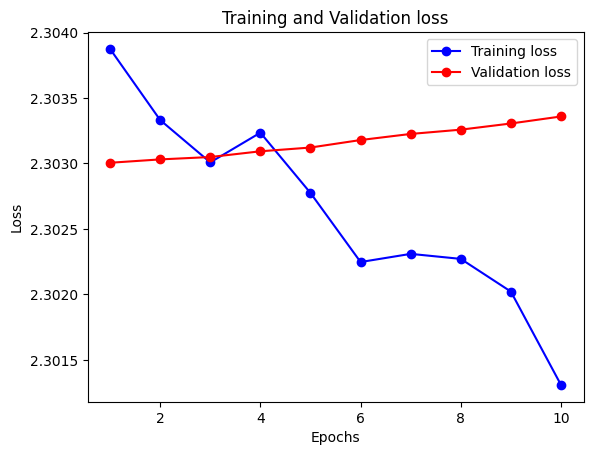

In [33]:
import matplotlib.pyplot as plt

# train_and_validate 함수로부터 손실 기록 받기
train_losses, val_losses = history

# 에포크 번호를 기준으로 그래프를 그립니다.
epochs = range(1, len(train_losses) + 1)

# 학습 및 검증 손실 그래프 그리기
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show() 

#### 학습 잘된 이미지 구글 검색

### 9. 모델 평가 해보기

In [42]:
# 모델 평가
evaluate(vgg16, testloader)

테스트 이미지 정확도 계산: 10.00%


0.10000000149011612

### 10. 최종 학습 모델 및 불러오기

#### 10-1. 모델 파라미터만 저장하기

In [52]:
torch.save(model.state_dict(), 'vgg16_model_weights.pth')

In [53]:
# 모델 구조 재생성
load_model = VGG16(num_classes=10)  # num_classes는 필요에 따라 조정
# 모델 파라미터 로드
load_model.load_state_dict(torch.load('vgg16_model_weights.pth'))
# 모델 출력해보기
print(load_model)

RuntimeError: Error(s) in loading state_dict for VGG16:
	size mismatch for classifier.6.weight: copying a param with shape torch.Size([1000, 4096]) from checkpoint, the shape in current model is torch.Size([10, 4096]).
	size mismatch for classifier.6.bias: copying a param with shape torch.Size([1000]) from checkpoint, the shape in current model is torch.Size([10]).

#### 10-2. 전체 모델 저장하기

In [48]:
torch.save(model, 'vgg16_model_full.pth')

In [50]:
load_model = torch.load('vgg16_model_full.pth')
print(load_model)

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation